In [18]:
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel

## Naive Sampling

In [20]:
def get_naive_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    # Call Naive Sampling
    mean, var, samples = naive_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
    if debug:
        print("Freq:", mean, "Var:", var)
        print("Produced samples")
        print("\n".join(tokenizer.batch_decode(samples)[::5]))

    return mean, var, samples


def assert_naive_result(samples, avoid_terms, naive_mean):
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # naive counting of number of sentences w/ one of the avoid terms
    counts = 0

    for i, sample in enumerate(samples):
        # print(i, tokenizer.decode(sample))
        for token_id in sample:
            if token_id.item() in avoid_terms_ids:
                #print(f"'{tokenizer.decode(token_id)}' appeared in sample {i}: '{tokenizer.decode(sample)}'")
                counts+=1
                break

    print("Total #(occur set A):", counts, f"(out of {len(samples)})")
    print("Output:", naive_mean)
    print("Expected:", 1 - counts / len(samples))
    assert np.abs(naive_mean - (1 - counts / len(samples))) <= 1e-8, "Naive sampling is wrong"

In [21]:
# User definitions
model_name = "gpt2"
seed = 42

num_samples = 200
input_str, avoid_terms = "I love", " the this that you u"

# ==========================================================
# Load models
tokenizer = GPT2Tokenizer.from_pretrained(model_name, model_max_length=512)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

naive_mean, _, naive_samples = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
assert_naive_result(naive_samples, avoid_terms, naive_mean)

Total #(occur set A): 102 (out of 200)
Output: 0.49000000953674316
Expected: 0.49


## Importance sampling

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from utils import set_seed
set_seed(42)

In [102]:
def get_imp_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    mean, var, samples = importance_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
    
    return mean, var, samples


def plot(mc_estimates, imp_estimates, tag):
    from scipy.stats import ttest_ind
    
    print("Difference of means:", np.mean(mc_estimates) - np.mean(imp_estimates))
    print("Naive sampling mean:", round(np.mean(mc_estimates), 4))
    print("Importance sampling mean:", round(np.mean(imp_estimates), 4))
    print("T-test (Weilch test, accounting for unequal variances):\n\t", ttest_ind(mc_estimates, imp_estimates, equal_var=False))

    df = pd.DataFrame({
        "Mean": mc_estimates + imp_estimates,
        "Method": len(mc_estimates) * ["Naive"] + len(imp_estimates) * ["Importance Sampling"]
    })

    sns.displot(data=df, x="Mean", hue="Method", kind="kde", rug=True, label="Naive sampling")
    plt.axvline(x=np.mean(mc_estimates), color='blue')
    plt.axvline(x=np.mean(imp_estimates), color='red')

    plt.title(tag);

In [103]:
SEEDS = np.unique(np.random.randint(0, 10**6, 70))
print("using", len(SEEDS), "seeds")

# User definitions
model_name = "gpt2"
num_samples = 10

# ==========================================================
# Load models
tokenizer = GPT2Tokenizer.from_pretrained(model_name, model_max_length=512)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

using 70 seeds


Difference of means: -0.01969528145023758
Naive sampling mean: 0.5414
Importance sampling mean: 0.5611
T-test (Weilch test, accounting for unequal variances):
	 Ttest_indResult(statistic=-0.9734339143536035, pvalue=0.33357947759286044)
CPU times: user 3min 27s, sys: 1.1 s, total: 3min 29s
Wall time: 20.9 s


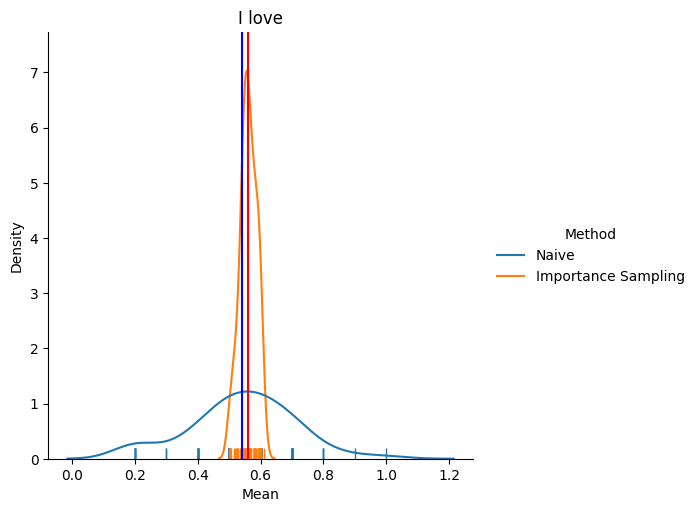

In [104]:
%%time
input_str, avoid_terms = "I love", " the this that you u"
mc_estimates = [get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
imp_estimates = [get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
plot(mc_estimates, imp_estimates, tag=input_str)

T-test (non-equal variance): Ttest_indResult(statistic=0.9540703784563249, pvalue=0.34385433729900483)
CPU times: user 15min 48s, sys: 3.69 s, total: 15min 51s
Wall time: 1min 35s


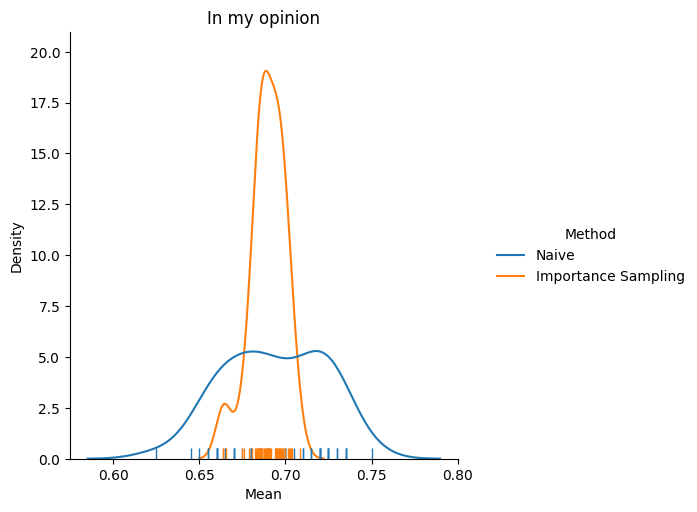

In [90]:
%%time
input_str, avoid_terms = "In my opinion", " the you she ."
mc_estimates = [get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
imp_estimates = [get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
plot(mc_estimates, imp_estimates, tag=input_str)

T-test (non-equal variance): Ttest_indResult(statistic=-0.7059611370442772, pvalue=0.4828921130780299)
CPU times: user 19min 34s, sys: 4.15 s, total: 19min 38s
Wall time: 1min 57s


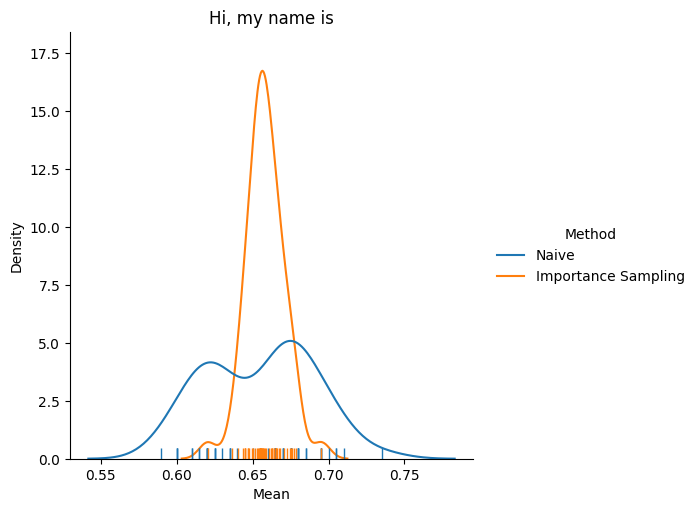

In [91]:
%%time
input_str, avoid_terms = "Hi, my name is", " John Mary."
mc_estimates = [get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
imp_estimates = [get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
plot(mc_estimates, imp_estimates, tag=input_str)

T-test (non-equal variance): Ttest_indResult(statistic=1.042564273300176, pvalue=0.30172927957101153)
CPU times: user 15min 47s, sys: 3.38 s, total: 15min 51s
Wall time: 1min 35s


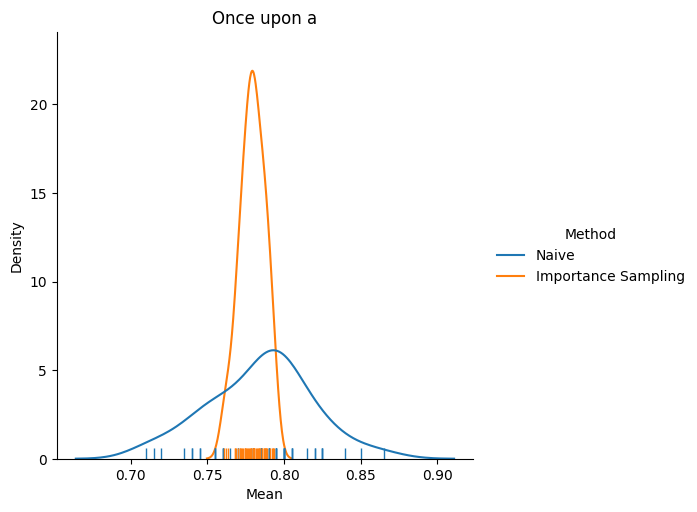

In [92]:
%%time
input_str, avoid_terms = "Once upon a", " time"
mc_estimates = [get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
imp_estimates = [get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
plot(mc_estimates, imp_estimates, tag=input_str)

T-test (non-equal variance): Ttest_indResult(statistic=0.8353706592037244, pvalue=0.4073943955995135)
CPU times: user 14min 3s, sys: 3.12 s, total: 14min 6s
Wall time: 1min 24s


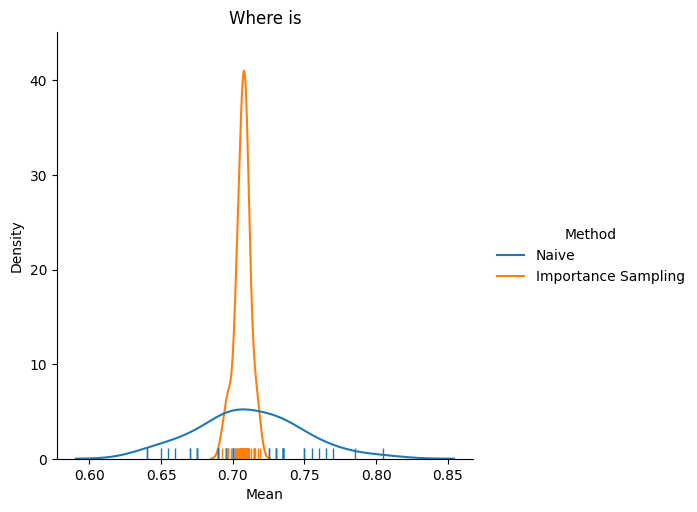

In [94]:
%%time
input_str, avoid_terms = "Where is", " the he she next city garden ."
mc_estimates = [get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
imp_estimates = [get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)[0] for seed in SEEDS]
plot(mc_estimates, imp_estimates, tag=input_str)

0.004302312433719591
